In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import IncrementalPCA
import sys
import os



In [18]:
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(os.path.dirname(current_dir), "..", "ada-2024-project-adadasurmonbidet2024"))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
    
from src.utils.data_utils import str_dict_to_values
from src.utils.results_utils import country_to_continent

In [19]:
df_char_cleaned = pd.read_csv('../data/cleaned.csv')

df_char_cleaned['Languages'] = df_char_cleaned['Languages'].apply(str_dict_to_values)
df_char_cleaned['Country'] = df_char_cleaned['Country'].apply(str_dict_to_values)
df_char_cleaned['Genres'] = df_char_cleaned['Genres'].apply(str_dict_to_values)

In [20]:

vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 3))
char_ngrams = vectorizer.fit_transform(df_char_cleaned['Character_name'])

# We create a Dataframe with the n-gram features
ngram_df = pd.DataFrame(char_ngrams.toarray(), columns=vectorizer.get_feature_names_out())
ngram_df = ngram_df.astype('float32') # converting to float32 to decrease the computing time

ngram_df.shape 
# We see that the dimentionality of ngram is very high, potentially increasing exponentially the processing time, we will deal with that later


(160432, 10186)

In [22]:
# To reduce n-gram dimentionality we use PCA
ipca = IncrementalPCA(n_components=9, batch_size=500)
pca_result = ipca.fit_transform(ngram_df)

In [23]:
loadings = pd.DataFrame(ipca.components_.T, columns=[f'PC{i+1}' for i in range(ipca.n_components_)], index=ngram_df.columns)

loadings['PC1']=loadings['PC1'].apply(abs)

print(loadings['PC1'].nlargest(10))

an     0.837831
ha     0.159982
nd     0.153868
ra     0.152212
and    0.148862
er     0.120076
na     0.119016
han    0.117958
ran    0.099292
ma     0.093544
Name: PC1, dtype: float64


The n-gram that influences the most the dimentionality with the most variance is 'an'

In [24]:
df_country = df_char_cleaned.copy()
df_country['pca_one'] = pca_result[:, 0]
df_country['pca_two'] = pca_result[:, 1]
df_country['pca_three'] = pca_result[:, 2]

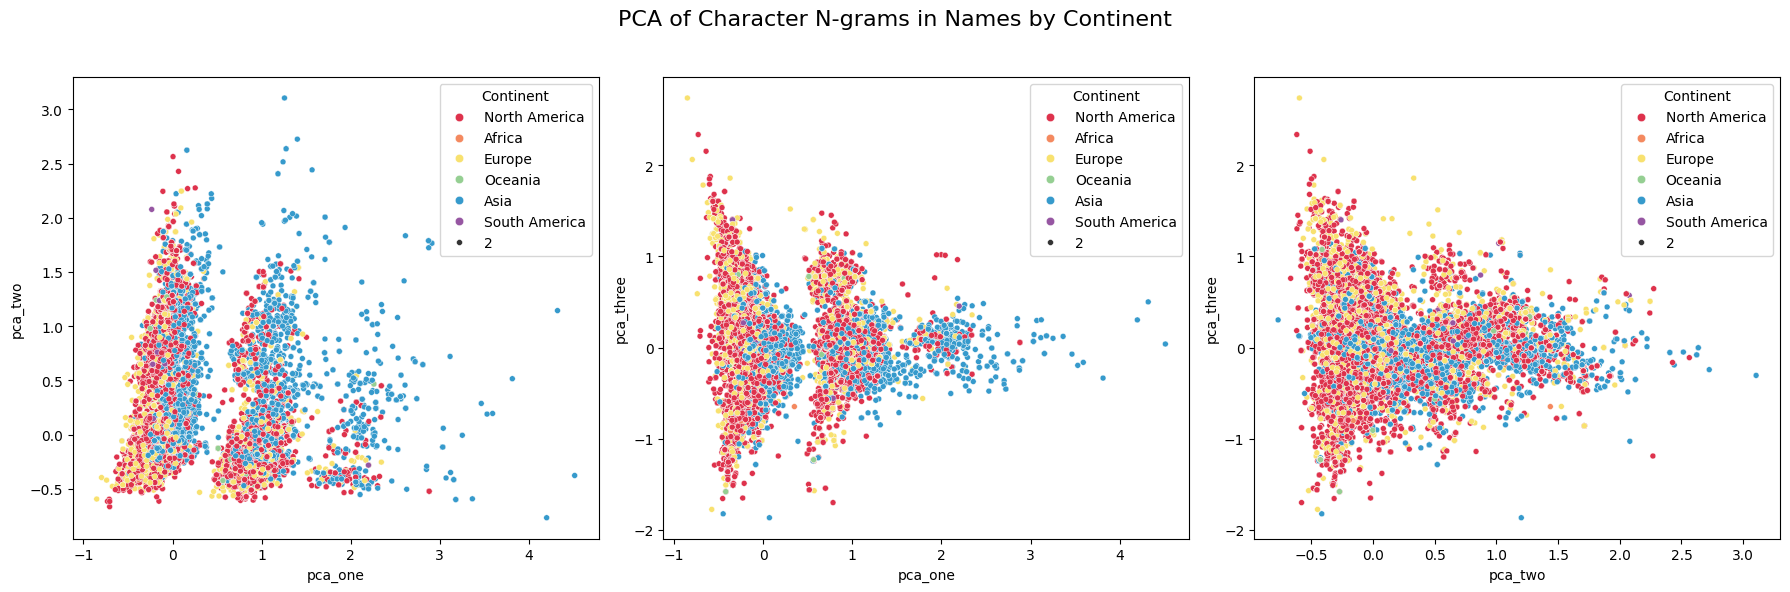

In [27]:
countries_code = []
df_char_cleaned['primary_country'] = df_char_cleaned['Country'].str[0]
df_country['Continent'] = df_char_cleaned['primary_country'].apply(lambda x: country_to_continent(x, countries_code=countries_code))

# Visualization
palette = ['#de324c','#f4895f','#f8e16f','#95cf92','#369acc','#9656a2']
fig,axs = plt.subplots(1,3,figsize=(18, 6))
fig.suptitle("PCA of Character N-grams in Names by Continent", fontsize=16)

sns.scatterplot(x="pca_one", y="pca_two", hue="Continent", data=df_country, palette=palette, size=2,linewidth=0.3, ax=axs[0])
sns.scatterplot(x="pca_one", y="pca_three", hue="Continent", data=df_country, palette=palette, size=2,linewidth=0.3, ax=axs[1])
sns.scatterplot(x="pca_two", y="pca_three", hue="Continent", data=df_country, palette=palette, size=2,linewidth=0.3, ax=axs[2])
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

We can see that distinct groups are created but they are not well related with the continent of origin of the movie.